In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader


Tải bộ dữ liệu MNIST

In [ ]:
# Chuẩn bị transform cho dữ liệu
transform = transforms.Compose([
    transforms.ToTensor(),  # Chuyển ảnh thành tensor
    transforms.Normalize((0.5,), (0.5,))  # Chuẩn hóa về khoảng [-1,1]
])

# Tải dữ liệu MNIST từ PyTorch datasets
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Chia batch dữ liệu
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Kiểm tra dữ liệu tải về
print(f"Tập train: {len(train_dataset)} ảnh")
print(f"Tập test: {len(test_dataset)} ảnh")


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.43MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 129kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.22MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.42MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Tập train: 60000 ảnh
Tập test: 10000 ảnh


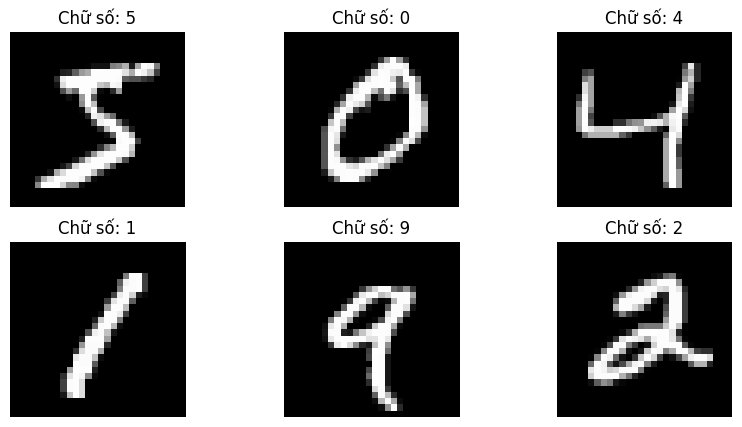

In [ ]:
# Hiển thị 6 ảnh đầu tiên từ tập train
plt.figure(figsize=(10,5))
for i in range(6):
    img, label = train_dataset[i]
    img = img.squeeze()  # Loại bỏ chiều channel (1,28,28) -> (28,28)

    plt.subplot(2,3,i+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"Chữ số: {label}")
    plt.axis("off")
plt.show()


Xây dựng CNN

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # Conv1
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Conv2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Conv3 (Thêm 1 lớp Conv)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 128),  # Fully connected 1
            nn.ReLU(),
            nn.Linear(128, 64),  # Fully connected 2
            nn.ReLU(),
            nn.Linear(64, 10)  # Output layer (10 chữ số)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Khởi tạo mô hình
model = CNNModel()


In [ ]:
loss_criterion = nn.CrossEntropyLoss()  # Hàm mất mát
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer Adam


Bắt đầu huấn luyện mô hình

🔹 Sử dụng thiết bị: cuda
✅ Epoch [1/10], Loss: 0.1905, Accuracy: 93.78%
✅ Epoch [2/10], Loss: 0.0486, Accuracy: 98.52%
✅ Epoch [3/10], Loss: 0.0364, Accuracy: 98.87%
✅ Epoch [4/10], Loss: 0.0263, Accuracy: 99.17%
✅ Epoch [5/10], Loss: 0.0217, Accuracy: 99.36%
✅ Epoch [6/10], Loss: 0.0182, Accuracy: 99.43%
✅ Epoch [7/10], Loss: 0.0163, Accuracy: 99.45%
✅ Epoch [8/10], Loss: 0.0139, Accuracy: 99.55%
✅ Epoch [9/10], Loss: 0.0113, Accuracy: 99.64%
✅ Epoch [10/10], Loss: 0.0112, Accuracy: 99.64%


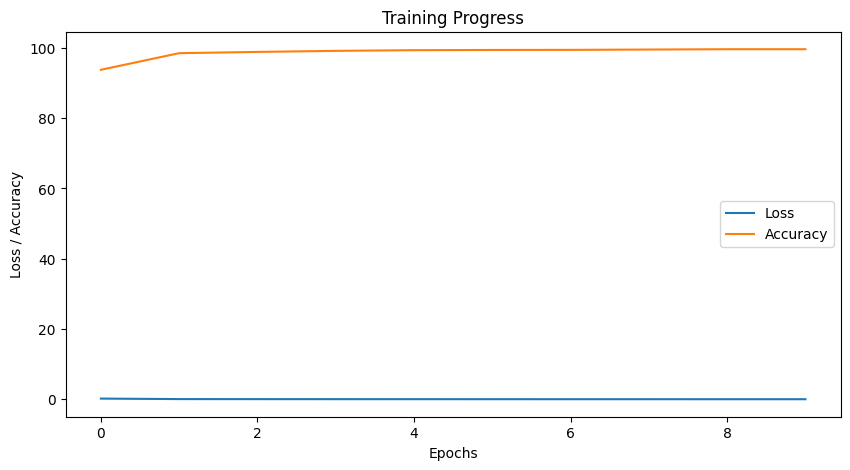

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Kiểm tra nếu có GPU thì dùng GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔹 Sử dụng thiết bị: {device}")

# Đưa mô hình lên GPU nếu có
model.to(device)

# Huấn luyện
epochs = 10  # Số vòng lặp huấn luyện
train_losses = []
train_accs = []

for epoch in range(epochs):
    model.train()  # Chuyển mô hình về chế độ train
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        # Chuyển dữ liệu lên GPU nếu có
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Reset gradient
        output = model(images)  # Forward pass
        loss = loss_criterion(output, labels)  # Tính loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Cập nhật trọng số

        running_loss += loss.item()
        _, predicted = torch.max(output, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accs.append(train_acc)

    print(f"✅ Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {train_acc:.2f}%")

# Vẽ biểu đồ Loss và Accuracy
plt.figure(figsize=(10,5))
plt.plot(range(epochs), train_losses, label="Loss")
plt.plot(range(epochs), train_accs, label="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss / Accuracy")
plt.legend()
plt.title("Training Progress")
plt.show()


Kiểm tra độ chính xác mô hình

In [ ]:
# Đánh giá mô hình trên tập test
model.eval()  # Chuyển mô hình sang chế độ đánh giá

correct = 0
total = 0

# Đưa model lên GPU nếu có
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    for images, labels in test_loader:
        # Đưa dữ liệu lên cùng thiết bị với mô hình
        images, labels = images.to(device), labels.to(device)

        # Dự đoán
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Tính độ chính xác
test_acc = 100 * correct / total
print(f"Độ chính xác trên tập test: {test_acc:.2f}%")


Độ chính xác trên tập test: 99.42%


Nhận diện ảnh chữ số

In [ ]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image

# Xác định thiết bị (CPU hoặc GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tải mô hình lên thiết bị đúng
model.to(device)

# Cho phép tải ảnh từ máy tính
uploaded = files.upload()

for filename in uploaded.keys():
    # Mở ảnh, chuyển grayscale
    img = Image.open(filename).convert("L")

    # Resize về 28x28
    img = img.resize((28, 28))

    # Chuyển thành NumPy array
    img = np.array(img)

    # Xử lý ảnh: Đảo ngược màu nếu cần (MNIST là nền đen, chữ trắng)
    if np.mean(img) > 127:  # Nếu nền trắng, chữ đen (ảnh tải lên thường bị ngược)
        img = 255 - img  # Đảo màu

    # Tăng độ tương phản
    img = cv2.equalizeHist(img.astype(np.uint8))

    # Hiển thị ảnh sau khi xử lý
    plt.imshow(img, cmap="gray")
    plt.title("Ảnh sau tiền xử lý")
    plt.axis("off")
    plt.show()

    # Chuẩn hóa ảnh về [0,1]
    img = img / 255.0

    # Định dạng ảnh cho model (1,1,28,28)
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Chuyển ảnh lên cùng thiết bị với mô hình
    img = img.to(device)

    # Dự đoán chữ số
    model.eval()
    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output, 1)

    print(f"📌 Mô hình dự đoán chữ số: {predicted.item()}")


Lưu mô hình vào drive và sử dung

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Định nghĩa đường dẫn lưu mô hình
model_path = "/content/drive/My Drive/cnn_model.pth"

# Lưu mô hình
torch.save(model.state_dict(), model_path)
print(f"Mô hình đã được lưu vào: {model_path}")

In [ ]:
# Định nghĩa lại kiến trúc mô hình trước khi load
model = CNNModel()  # Đảm bảo CNNModel đã được định nghĩa

# Tải trọng số vào mô hình
model.load_state_dict(torch.load(model_path))
model.eval()  # Chuyển sang chế độ đánh giá
print("Mô hình đã được tải thành công!")


<ipython-input-29-d2682f418a5b>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Mô hình đã được tải thành công!


Saving SO_8.jpg to SO_8.jpg


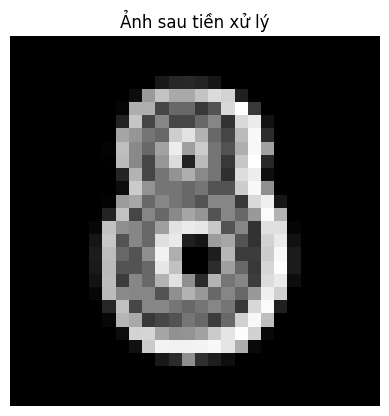

📌 Mô hình dự đoán chữ số: 3


In [ ]:
 import cv2
import numpy as np
import torch
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt

# Cho phép tải ảnh từ máy tính
uploaded = files.upload()

for filename in uploaded.keys():
    # Mở ảnh, chuyển grayscale
    img = Image.open(filename).convert("L")

    # Resize về 28x28
    img = img.resize((28, 28))

    # Chuyển thành NumPy array
    img = np.array(img)

    # Xử lý ảnh: Đảo ngược màu nếu cần (MNIST là nền đen, chữ trắng)
    if np.mean(img) > 127:  # Nếu nền trắng, chữ đen (ảnh tải lên thường bị ngược)
        img = 255 - img  # Đảo màu

    # Tăng độ tương phản
    img = cv2.equalizeHist(img.astype(np.uint8))

    # Hiển thị ảnh sau khi xử lý
    plt.imshow(img, cmap="gray")
    plt.title("Ảnh sau tiền xử lý")
    plt.axis("off")
    plt.show()

    # Chuẩn hóa ảnh về khoảng [0,1]
    img = img / 255.0

    # Chuyển ảnh thành Tensor và đảm bảo có shape (1,1,28,28)
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Chạy mô hình để dự đoán
    model.eval()
    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output, 1)

    print(f"📌 Mô hình dự đoán chữ số: {predicted.item()}")
